## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [12]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
import itertools
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [13]:
train, test = keras.datasets.cifar10.load_data()

In [14]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [15]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [16]:

def build_mlp(input_shape, output_units=10, num_neuron=[1024,512,256], drop_rate=0.3):

    input_layer = keras.layers.Input(input_shape)
    
    for i, num in enumerate(num_neuron):
        if i == 0:
            x = keras.layers.Dense(units=num, activation = "relu")(input_layer)
            x = keras.layers.Dropout(drop_rate)(x)
        else:
            x = keras.layers.Dense(units=num, activation = "relu")(x)
            x = keras.layers.Dropout(drop_rate)(x)
    out = keras.layers.Dense(units=output_units, activation= "sigmoid")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [23]:
"""Code Here
設定超參數
"""
LEARNING_RATE = [1e-2,1e-3, 1e-4, 1e-5]
EPOCHS = 150
BATCH_SIZE = 512
PATIENCE = [10,25]
MOMENTUM = 0.95

In [24]:
results = {}

for lr, patience in itertools.product(LEARNING_RATE, PATIENCE):
    keras.backend.clear_session()
    early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=patience)
    
    model = build_mlp(x_train.shape[1:])
    
    opt = keras.optimizers.SGD(learning_rate=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer=opt)
    
    model.fit(x_train, y_train,
              epochs = EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test,y_test),
              shuffle=True,
              callbacks=[early_stop]
             )
    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    tag = "LR=%s, Patience=%s" % (str(lr),str(patience))
    results[tag] ={'train_acc':train_acc,
                   'train_loss':train_loss,
                   'valid_acc':valid_acc,
                   'valid_loss':valid_loss
                  }

Epoch 1/150
98/98 [==============================] - 1s 9ms/step - loss: 2.1330 - accuracy: 0.1999 - val_loss: 1.9130 - val_accuracy: 0.3123
Epoch 2/150
98/98 [==============================] - 1s 9ms/step - loss: 1.8978 - accuracy: 0.3097 - val_loss: 1.7711 - val_accuracy: 0.3683
Epoch 3/150
98/98 [==============================] - 1s 9ms/step - loss: 1.7908 - accuracy: 0.3533 - val_loss: 1.6734 - val_accuracy: 0.4150
Epoch 4/150
98/98 [==============================] - 1s 9ms/step - loss: 1.7260 - accuracy: 0.3802 - val_loss: 1.6209 - val_accuracy: 0.4272
Epoch 5/150
98/98 [==============================] - 1s 9ms/step - loss: 1.6761 - accuracy: 0.4018 - val_loss: 1.5678 - val_accuracy: 0.4500
Epoch 6/150
98/98 [==============================] - 1s 9ms/step - loss: 1.6387 - accuracy: 0.4130 - val_loss: 1.5411 - val_accuracy: 0.4476
Epoch 7/150
98/98 [==============================] - 1s 9ms/step - loss: 1.6079 - accuracy: 0.4245 - val_loss: 1.5282 - val_accuracy: 0.4562
Epoch 8/150
9

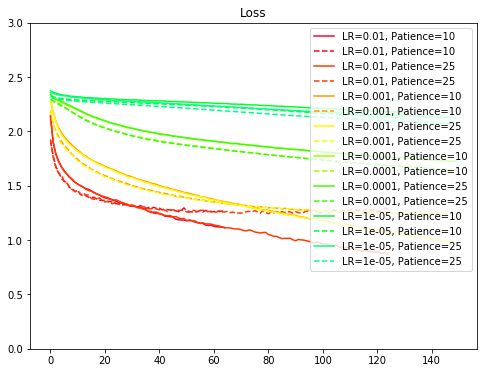

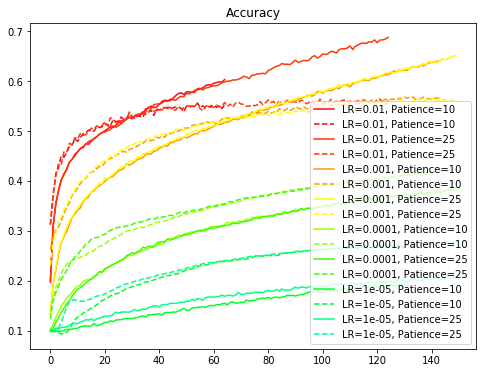

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 15

cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'],'-',color=color_bar[i],label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'],'--',color=color_bar[i],label=cond)
plt.ylim([0, 3])
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'],'-',color=color_bar[i],label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'],'--',color=color_bar[i],label=cond)
plt.title('Accuracy')
plt.legend()
plt.show()